### Lab 2.

In [68]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.functional as F
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pytorch_lightning as pl
import typing
import torchvision
from torchvision import transforms
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sorok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
df = pd.read_csv("data.csv", sep=';')
df.isna().any()

title          False
genre          False
description     True
img_link       False
dtype: bool

In [70]:
df = df.dropna()

In [71]:
df.isna().any()

title          False
genre          False
description    False
img_link       False
dtype: bool

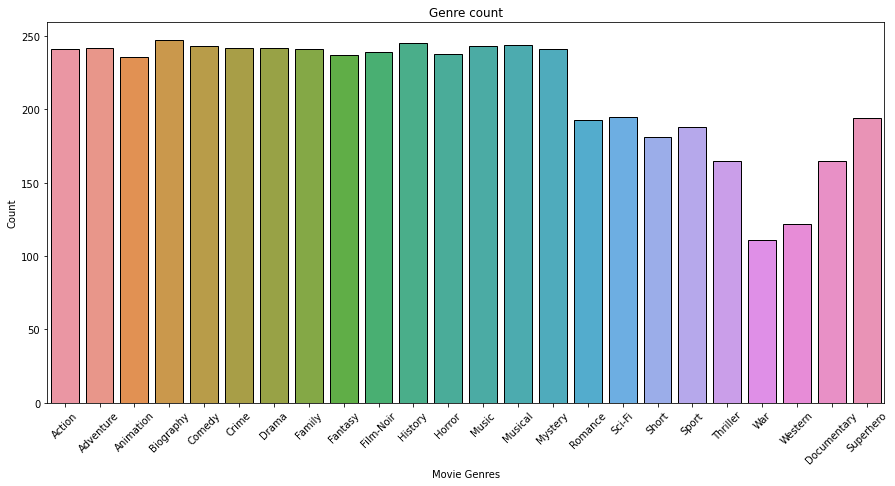

In [72]:
plt.figure(figsize=(15,7))
sns.countplot(x='genre', data=df, edgecolor=(0,0,0))
plt.xticks(rotation=45)
plt.xlabel('Movie Genres')
plt.ylabel('Count')
plt.title('Genre count')
plt.show()

In [73]:
df.head()

,title,genre,description,img_link
0,Black Panther: Wakanda Forever,Action,The people of Wakanda fight to protect their h...,Action_01.jpg
1,Andor,Action,Prequel series to Star Wars' 'Rogue One'. In a...,Action_02.jpg
2,Black Adam,Action,"Nearly 5,000 years after he was bestowed with ...",Action_03.jpg
3,House of the Dragon,Action,An internal succession war within House Targar...,Action_04.jpg
4,Warrior Nun,Action,"After waking up in a morgue, an orphaned teen ...",Action_05.jpg


In [74]:
#genre_mapper = {'Action': 0, 'Adventure': 1, 'Animation': 2, 'Biography':3, 'Comedy':4, 'Crime':5, 'Documentary':6, 'Drama':7, 'Family': 8,
#                'Fantasy': 9, 'Film-Noir': 10, 'History': 11, 'Horror':12, 'Music':13, 'Musical':14, 'Mystery':15, 'Romance':16, 'Sci-Fi': 17,
#                'Short': 18, 'Sport': 19, 'Superhero': 20, 'Thriller':21, 'War':22, 'Western':23}
#df['genre'] = df['genre'].map(genre_mapper)
#df.head(10)

### Text preprocessing

In [75]:
# Text preprocessing

def preprocess_text(text, stemm=False, lemm=True, stopwords=None):
  # Remove punctuations, lowercase, strip
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
          
  # Tokenize
  texts = text.split()    
  # Remove Stopwords
  if stopwords is not None:
      texts = [word for word in texts if word not in stopwords]
              
  # Stemming
  if stemm == True:
      ps = nltk.stem.porter.PorterStemmer()
      texts = [ps.stem(word) for word in texts]
              
  # Lemmatisation
  if lemm == True:
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      texts = [lem.lemmatize(word) for word in texts]
          
  # Collect lists
  text = " ".join(texts)
  return text

In [76]:
# Loading stopwords dict
stopwords = nltk.corpus.stopwords.words("english")

In [77]:
# Doing preprocessing on texts
df['clean_title'] = df["title"].apply(lambda x: 
          preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
df['clean_description'] = df["description"].apply(lambda x: 
          preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
df.head()

,title,genre,description,img_link,clean_title,clean_description
0,Black Panther: Wakanda Forever,Action,The people of Wakanda fight to protect their h...,Action_01.jpg,black panther wakanda forever,people wakanda fight protect home intervening ...
1,Andor,Action,Prequel series to Star Wars' 'Rogue One'. In a...,Action_02.jpg,andor,prequel series star war rogue one era filled d...
2,Black Adam,Action,"Nearly 5,000 years after he was bestowed with ...",Action_03.jpg,black adam,nearly 5000 year bestowed almighty power egypt...
3,House of the Dragon,Action,An internal succession war within House Targar...,Action_04.jpg,house dragon,internal succession war within house targaryen...
4,Warrior Nun,Action,"After waking up in a morgue, an orphaned teen ...",Action_05.jpg,warrior nun,waking morgue orphaned teen discovers posse su...


In [78]:
#one_hot = pd.get_dummies(df['genre'])
#df = df.drop(['genre'], axis = 1)
#df = df.join(one_hot)
#df

In [79]:
#df.to_csv('data_cleaned.csv', sep=';', index=None)

In [80]:
#genre_mapper = {'Action': 0, 'Adventure': 1, 'Animation': 2, 'Biography':3, 'Comedy':4, 'Crime':5, 'Documentary':6, 'Drama':7, 'Family': 8,
#                'Fantasy': 9, 'Film-Noir': 10, 'History': 11, 'Horror':12, 'Music':13, 'Musical':14, 'Mystery':15, 'Romance':16, 'Sci-Fi': 17,
#                'Short': 18, 'Sport': 19, 'Superhero': 20, 'Thriller':21, 'War':22, 'Western':23}
#df['genre'] = df['genre'].map(genre_mapper)
#df.head(10)

In [81]:
df["text"] = df["clean_title"] + " " + df["clean_description"]
df = df[['text', 'genre', 'img_link']]
df.head()

,text,genre,img_link
0,black panther wakanda forever people wakanda f...,Action,Action_01.jpg
1,andor prequel series star war rogue one era fi...,Action,Action_02.jpg
2,black adam nearly 5000 year bestowed almighty ...,Action,Action_03.jpg
3,house dragon internal succession war within ho...,Action,Action_04.jpg
4,warrior nun waking morgue orphaned teen discov...,Action,Action_05.jpg


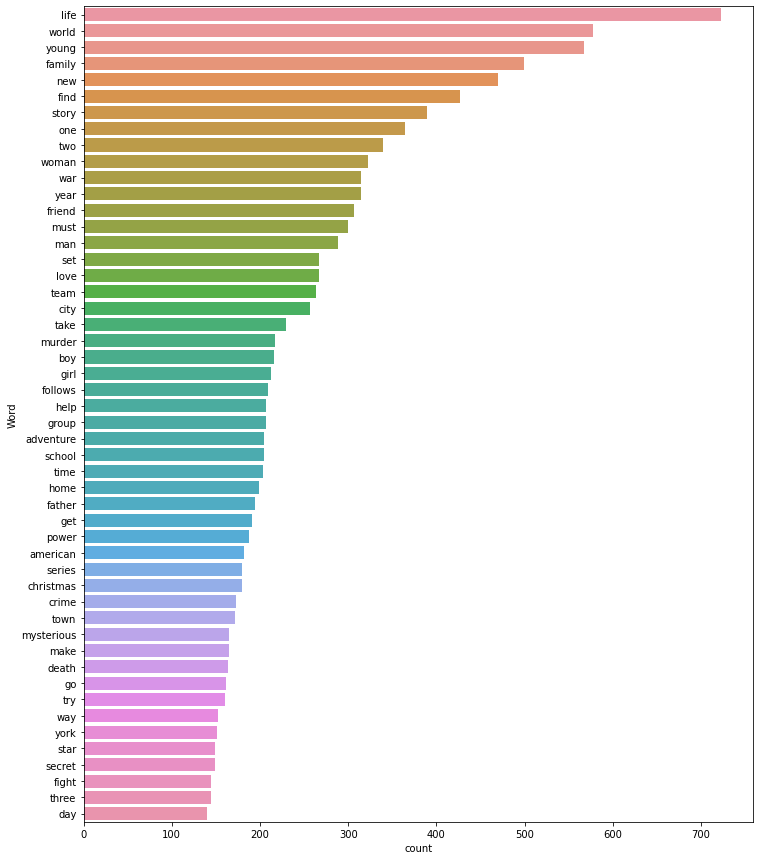

In [99]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df['text'], 50)

In [83]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genre'])

# transform target variable
y = multilabel_binarizer.transform(df['genre'])

In [84]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [85]:
xtrain, xval, ytrain, yval = train_test_split(df['text'], y, test_size=0.2, random_state=9)

In [86]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [87]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [88]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [89]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [90]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [91]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0])

In [93]:
f1_score(yval, y_pred, average="micro")
# this is for threshhold 0.5

0.33767400089806915

In [94]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [95]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [98]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.4975946004164572